# 데이터 불러오기
- 데이터 형태는 
- X = (3950, 20)과 같이 (전체 데이터 개수, voca_size)
- y = (3950,1) 과같이 (전체 데이터 개수, 정수)

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import wandb
from wandb.keras import WandbCallback
from sklearn.preprocessing import LabelEncoder

In [2]:
train_data_path ="/aiffel/aiffel/dlthon_team5/data/train.csv"
train_data = pd.read_csv(train_data_path)

# 클래스 한글이름을 숫자로 변경 - (사빈님 수정예정)
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화']
encoder = LabelEncoder()
encoder.fit(CLASS_NAMES)
train_data['class'] = encoder.transform(train_data['class'])

corpus = train_data["conversation"]

In [3]:
# 토큰화 + encoding 진행 
# 변수 = voca_size, 토큰화 방법

def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=1000, 
        filters=' ',
        oov_token="<unk>")
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)   
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=20)  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  1 210   1 ...   1  41   1]
 [  1   1   1 ...   1   1 396]
 [  1  96   1 ...   1 125   1]
 ...
 [485   3 113 ...  27   1   1]
 [  1   1 152 ... 350   1   1]
 [  1   1   1 ... 156 114   1]] <keras_preprocessing.text.Tokenizer object at 0x7b172b1ecc10>


In [6]:
# (데이터 개수, max_length)
tensor.shape

(3950, 20)

In [4]:
# 학습 데이터셋과 val 그리고 필요하다면 test 데이터셋 준비
X_train = tensor[:3500]
y_train = train_data['class'][:3500]
X_val = tensor[3500:3850]
y_val = train_data['class'][3500:3850]
X_test = tensor[3850:]
y_test = train_data['class'][3850:]

In [5]:
# 배치 및 버퍼 크기
BATCH_SIZE = 64
BUFFER_SIZE = 10000

# 학습용 데이터셋을 tf.data.Dataset으로 변환
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': X_train,   # 대화 데이터
    },
    {
        'outputs': y_train,  # 분류 레이블
    }
))

# 검증용 데이터셋을 tf.data.Dataset으로 변환
val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': X_val,
    },
    {
        'outputs': y_val,
    }
))

# 테스트용 데이터셋을 tf.data.Dataset으로 변환
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': X_test,
    },
    {
        'outputs': y_test,
    }
))

# 데이터셋을 섞고, 배치 처리
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# 모델

In [7]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [8]:
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output


In [9]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

In [10]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [11]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [12]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [13]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])
    
    pooled_outputs = tf.keras.layers.GlobalAveragePooling1D()(enc_outputs)
    pooled_outputs = tf.keras.layers.Dropout(rate=dropout)(pooled_outputs)
    
    # encoder output size = (batch_size, sentence_length, embedding_dim)
    # 분류 문제를 위한 완전 연결층
    # 완전연결층
    outputs = tf.keras.layers.Dense(units=1028, activation='relu', name="linear_hidden_layer")(pooled_outputs)
    outputs = tf.keras.layers.Dense(units=5, activation='softmax', name="outputs")(outputs)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

In [14]:
tf.keras.backend.clear_session()

# 하이퍼파라미터

VOCAB_SIZE = 1000

NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    1310208     inputs[0][0]                     
                                                                 enc_padding_mask[0][0]           
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 256)          0           encoder[0][0]          

In [15]:
def loss_function(y_true, y_pred):
#     num_classes = 5
#     y_true = tf.one_hot(y_true, depth=num_classes)
    y_true = tf.squeeze(y_true, axis=-1)
    # softmax 함수를 통과한 값이 나오기때문에 False를 사용
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False)(y_true, y_pred)

#     mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
#     loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [16]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [17]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [18]:
EPOCHS = 10
history = model.fit(
    train_dataset,
    validation_data=val_dataset,  # 검증 데이터셋 추가
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/10
55/55 [==============================] - 5s 22ms/step - loss: 1.5448 - accuracy: 0.2554 - val_loss: 1.4117 - val_accuracy: 0.2571
Epoch 2/10
55/55 [==============================] - 1s 11ms/step - loss: 1.3992 - accuracy: 0.2809 - val_loss: 1.4050 - val_accuracy: 0.2514
Epoch 3/10
55/55 [==============================] - 1s 11ms/step - loss: 1.3891 - accuracy: 0.2983 - val_loss: 1.3697 - val_accuracy: 0.3429
Epoch 4/10
55/55 [==============================] - 1s 11ms/step - loss: 1.3449 - accuracy: 0.3403 - val_loss: 1.3462 - val_accuracy: 0.2886
Epoch 5/10
55/55 [==============================] - 1s 11ms/step - loss: 1.2298 - accuracy: 0.4391 - val_loss: 1.1695 - val_accuracy: 0.5000
Epoch 6/10
55/55 [==============================] - 1s 11ms/step - loss: 1.0833 - accuracy: 0.5397 - val_loss: 1.1016 - val_accuracy: 0.5314
Epoch 7/10
55/55 [==============================] - 1s 11ms/step - loss: 0.9639 - accuracy: 0.6151 - val_loss: 1.0608 - val_accuracy: 0.5229
Epoch 8/10
55

Text(0.5, 1.0, 'train_acc')

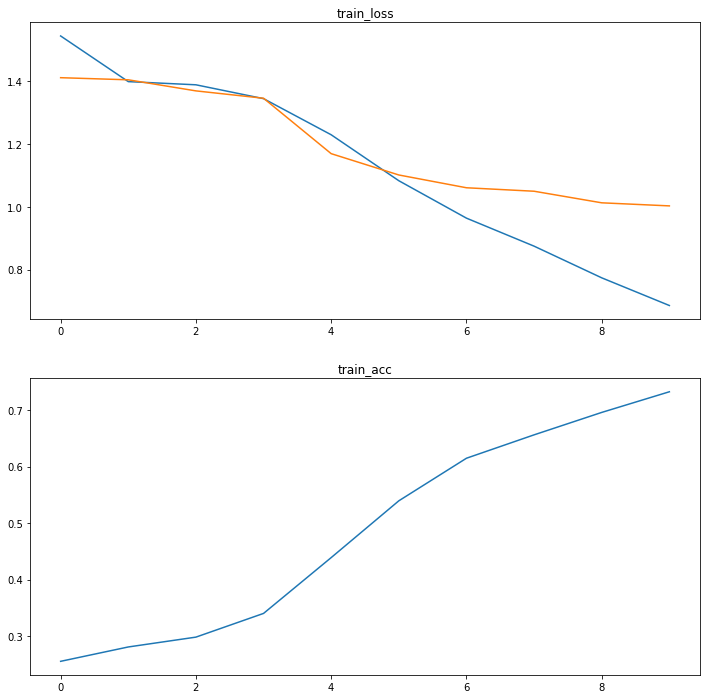

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,1, figsize=(12,12))

axs[0].plot(history.history['loss'], label='train')
axs[0].plot(history.history['val_loss'], label='train')
axs[0].set_title('train_loss')
axs[1].plot(history.history['accuracy'], label='train')
axs[1].set_title('train_acc')

In [22]:
model.evaluate(test_dataset)

2/2 [==============================] - 0s 8ms/step - loss: 1.0857 - accuracy: 0.6100


[1.0856871604919434, 0.6100000143051147]

# 하이퍼 파라미터 튜닝용

In [ ]:
sweep_config = {
    "name": "sweep_test_nlp",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {

        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            },
        
        "drop_out" : {
            "min": 0.1,
            "max": 0.4
        }
                    
        }
    }